# import modules

In [2]:
print('Loading libraries...')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import RegularPolygon, Polygon, Circle
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.transforms import Affine2D
from matplotlib.spines import Spine
from matplotlib.path import Path
import math
import seaborn as sns

Loading libraries...


# indiv plots

In [ ]:
def radar_factory(num_vars, frame='polygon', horizontal_scale=0.3, is_diamond=False):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'polygon' and is_diamond:
                # Diamond shape for 2-variable datasets expanded to 4 points
                diamond_verts = np.array([
                    [0.5, 1.0],                          # Top
                    [0.5 + 0.5*horizontal_scale, 0.5],   # Right (compressed)
                    [0.5, 0.0],                          # Bottom
                    [0.5 - 0.5*horizontal_scale, 0.5],   # Left (compressed)
                ])
                return Polygon(diamond_verts, edgecolor="k", linewidth=2, closed=True)
            elif frame == 'polygon':
                # Regular polygon for all other cases (including actual 4-variable data)
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k", linewidth=2)
            elif frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'polygon' and is_diamond:
                # Diamond spine for 2-variable datasets
                verts = np.array([
                    [0, 1],                    # Top
                    [horizontal_scale, 0],     # Right (compressed)
                    [0, -1],                   # Bottom
                    [-horizontal_scale, 0],    # Left (compressed)
                ])
                path = Path(np.vstack([verts, verts[0]]), 
                           [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
                spine = Spine(axes=self, spine_type='circle', path=path)
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'circle':
                return super()._gen_axes_spines()
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

def create_radar_chart(categories, data, category_colors, title, horizontal_scale=0.3):
    """
    Create a radar chart with colors assigned by category.
    
    Parameters:
    - categories: list of category names
    - data: list of lists, each inner list is a dataset with values for each category
    - category_colors: list of colors for each category (must match length of categories)
    - title: chart title
    - horizontal_scale: compression factor for diamond charts
    """
    num_vars = len(categories)
    
    # Validate that colors match categories
    if len(category_colors) != num_vars:
        raise ValueError(f"Number of colors ({len(category_colors)}) must match number of categories ({num_vars})")

    # ========== 2-Class Diamond Mode ==========
    diamond_mode = False
    if num_vars == 2:
        diamond_mode = True
        # For diamond, use 4 points (top, right, bottom, left)
        theta = radar_factory(4, horizontal_scale=horizontal_scale, is_diamond=True)
        
        # Store original colors before expanding
        original_colors = category_colors.copy()
        
        # Pad categories and data for diamond format
        categories = [categories[0], '', categories[1], '']  # Blank side labels
        # Expand colors to match the 4-point format (but sides won't be used)
        category_colors = [original_colors[0], '', original_colors[1], '']
        
        padded_data = []
        for d in data:
            if len(d) != 2:
                raise ValueError("2-class data requires exactly 2 values per dataset")
            padded_data.append([d[0], 0, d[1], 0])  # Add zero-valued side points
        data = padded_data
        num_vars = 4
    else:
        theta = radar_factory(num_vars, is_diamond=False)
    # ========== End 2-Class Mode ==========

    fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))

    # Normalization (modified for diamond mode)
    normalized_data = []
    for d in data:
        row_sum = sum(d)
        if not diamond_mode:
            norm_d = [val/row_sum for val in d]
        else:
            # Only top and bottom are nonzero
            norm_d = [
                d[0]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,  # Top
                0,                                             # Right (keep zero)
                d[2]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,  # Bottom
                0                                              # Left (keep zero)
            ]
        normalized_data.append(norm_d)

    # Turn off all default grid
    ax.grid(False)

    # Create custom polygonal grid lines
    grid_values = np.linspace(0.1, 1, 6)  # Adjusted grid values (proportions)
    for g in grid_values:
        if diamond_mode:
            # Draw compressed diamond grid lines
            r = [g, g*horizontal_scale, g, g*horizontal_scale, g]  # Compressed sides
            ax.plot(np.append(theta, theta[0]), r, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        else:
            # Regular polygon grid
            polygon_vertices = []
            for t in theta:
                polygon_vertices.append((t, g))
            polygon_vertices.append((theta[0], g))  # Close the polygon correctly
            ax.plot(*zip(*polygon_vertices), color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    # Add radial lines connecting origin to each variable
    for t in theta:
        ax.plot([t, t], [0.1, 1], color='black', linestyle='--', linewidth=0.5, alpha=0.7)

    # Plot only the maximum value of each dataset
    # Now with category-based coloring
    for i, d in enumerate(normalized_data):
        max_value_index = np.argmax(d)
        
        # Use color based on category (not dataset)
        if diamond_mode:
            # In diamond mode, map back to original category
            if max_value_index == 0:
                category_color = original_colors[0]  # Top point uses first category color
            elif max_value_index == 2:
                category_color = original_colors[1]  # Bottom point uses second category color
            else:
                # This shouldn't happen as sides are always zero
                category_color = 'gray'
        else:
            # Regular mode - use the category's color directly
            category_color = category_colors[max_value_index]
        
        ax.scatter(theta[max_value_index], d[max_value_index], s=100, 
                  color=category_color, marker='x')

    ax.set_varlabels(categories)
    ax.set_ylim(0.1, 1)
    ax.set_yticks([])
    
    plt.title(title, y=1.1 if diamond_mode else 1.05)  # Adjust title position
    
    # Create a legend for categories instead of datasets
    if not diamond_mode:
        legend_elements = []
        for i, cat in enumerate(categories):
            if cat:  # Skip empty category labels (sides in diamond mode)
                legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                               markerfacecolor=category_colors[i], 
                                               markersize=10, label=cat))
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))
    else:
        # Diamond mode - only show the two actual categories
        legend_elements = [
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=original_colors[0], 
                     markersize=10, label=categories[0]),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=original_colors[1], 
                     markersize=10, label=categories[2])  # Index 2 has the second category
        ]
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))
    
    return fig, ax

if __name__ == "__main__":
    # Example: Diamond (2 variables)
    categories = ['Speed', 'Accuracy']
    data = [[88, 78],
 [64, 92],
 [57, 70],
 [88, 68],
 [72, 60]]
    category_colors = ['#FF5733', '#33FF57'] 
    create_radar_chart(categories, data, category_colors,
                       title="2-Variable Diamond Chart")

    # Example: Square (4 variables)
    categories = ['North', 'East', 'South', 'West']
    data = [[30, 23, 27, 22],
 [21, 31, 25, 21],
 [20, 31, 31, 36],
 [29, 35, 34, 34],
 [38, 31, 39, 22]]
    category_colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12']
    create_radar_chart(categories, data, category_colors,
                       title="4-Variable Square Chart")

    # Example: Pentagon (5 variables)
    categories = ['Strength', 'Agility', 'Endurance', 'Intelligence', 'Charisma']
    data = [[86, 56, 70, 58, 88],
 [67, 53, 74, 63, 99],
 [58, 75, 51, 69, 77],
 [96, 56, 93, 57, 96],
 [84, 63, 66, 85, 99]]
    category_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
    create_radar_chart(categories, data,
                       category_colors,
                       title="5-Variable Pentagon Chart")

    plt.show()


# multiple subplot

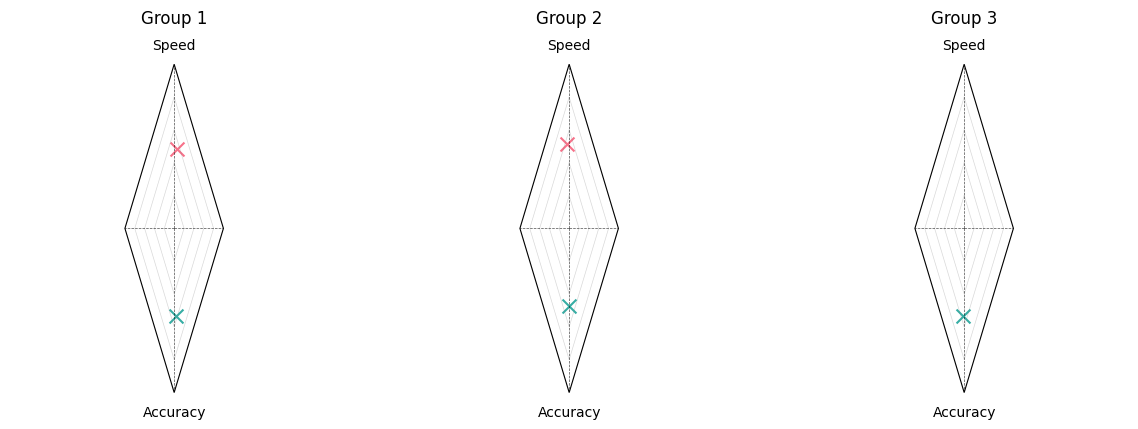

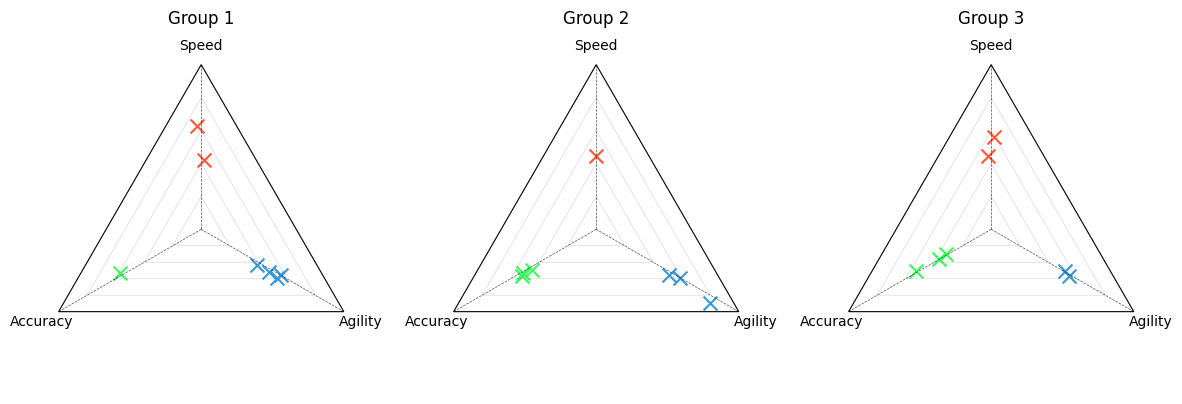

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from matplotlib.patches import RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.transforms import Affine2D
from matplotlib.spines import Spine
import math
import pandas as pd
import seaborn as sns

def radar_factory(num_vars, frame='polygon', horizontal_scale=0.3, is_diamond=False):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'polygon' and is_diamond:
                diamond_verts = np.array([
                    [0.5, 1.0],
                    [0.5 + 0.5*horizontal_scale, 0.5],
                    [0.5, 0.0],
                    [0.5 - 0.5*horizontal_scale, 0.5],
                ])
                return Polygon(diamond_verts, edgecolor="k", linewidth=2, closed=True)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k", linewidth=2)
            elif frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'polygon' and is_diamond:
                verts = np.array([
                    [0, 1],
                    [horizontal_scale, 0],
                    [0, -1],
                    [-horizontal_scale, 0],
                ])
                path = Path(np.vstack([verts, verts[0]]),
                           [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
                spine = Spine(axes=self, spine_type='circle', path=path)
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'circle':
                return super()._gen_axes_spines()
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def create_radar_chart(categories, data, category_colors, title, horizontal_scale=0.3, ax=None):
    num_vars = len(categories)
    min_y = 0
    max_y = 1.1

    if len(category_colors) != num_vars:
        raise ValueError(f"Number of colors ({len(category_colors)}) must match number of categories ({num_vars})")

    diamond_mode = False
    if num_vars == 2:
        diamond_mode = True
        num_vars = 4
        theta = radar_factory(num_vars, horizontal_scale=horizontal_scale, is_diamond=True)
        original_colors = category_colors.copy()
        categories = [categories[0], '', categories[1], '']
        category_colors = [original_colors[0], '', original_colors[1], '']
        padded_data = []
        for d in data:
            if len(d) != 2:
                raise ValueError("2-class data requires exactly 2 values per dataset")
            padded_data.append([d[0], 0, d[1], 0])
        data = padded_data
        num_vars = 4
    else:
        theta = radar_factory(num_vars, is_diamond=False)

    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    else:
        fig = ax.figure

    normalized_data = []
    for d in data:
        row_sum = sum(d)
        if not diamond_mode:
            norm_d = [val / row_sum if row_sum != 0 else 0 for val in d]
        else:
            norm_d = [
                d[0]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,
                0,
                d[2]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,
                0
            ]
        normalized_data.append(norm_d)

    ax.grid(False)
    grid_values = np.linspace(min_y, max_y, 6)

    for g in grid_values:
        if diamond_mode:
            r = [g, g*horizontal_scale, g, g*horizontal_scale, g]
            ax.plot(np.append(theta, theta[0]), r, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        else:
            polygon_vertices = [(t, g) for t in theta]
            polygon_vertices.append((theta[0], g))
            ax.plot(*zip(*polygon_vertices), color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    for t in theta:
        ax.plot([t, t], [min_y, max_y], color='black', linestyle='--', linewidth=0.5, alpha=0.7)

    for i, d in enumerate(normalized_data):
        max_value_index = np.argmax(d)
        category_color = (
            original_colors[0] if diamond_mode and max_value_index == 0 else
            original_colors[1] if diamond_mode and max_value_index == 2 else
            'gray' if diamond_mode else category_colors[max_value_index]
        )
        theta_jitter = theta[max_value_index] + np.random.uniform(-0.05, 0.05)
        ax.scatter(theta_jitter, d[max_value_index], s=100, color=category_color, marker='x')

    ax.set_varlabels(categories)
    ax.set_ylim(min_y, max_y)
    ax.set_yticks([])
    ax.set_title(title, y=1.1)
    return fig, ax

def auto_subplot_grid(n):
    """Finds a near-square grid for `n` subplots."""
    rows = math.isqrt(n)
    cols = math.ceil(n / rows)
    return rows, cols


def plot_radar_charts(df, categories = None, colors = None, titles=None):

    """
    categories: List of categories for the radar chart. If None, the columns of the DataFrame will be used.
    colors: List of colors for each category. If None, a default color scheme will be used.
    titles: List of titles for each radar chart. If None, the index of the DataFrame will be used.
    """
    if categories is None:
        categories = df.columns.tolist()
    num_vars = len(categories)

    # Set default color scheme if none is provided
    if colors is None:
        # Generate a default color palette (e.g., using seaborn)
        colors = sns.color_palette("husl", len(categories))  # 'husl' is a good distinct color palette

    # Register projection dynamically
    radar_factory(4 if num_vars == 2 else num_vars, is_diamond=True if num_vars == 2 else False)
    # Group data by index
    grouped = df.groupby(df.index)

    num_charts = len(grouped)  # Number of distinct indices
    rows, cols = auto_subplot_grid(num_charts)
    fig, axs = plt.subplots(rows, cols, subplot_kw=dict(projection='radar'), figsize=(cols * 4, rows * 4))
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    # Create radar charts for each group of rows with the same index
    for i, (index, group) in enumerate(grouped):
        if titles is None:
            title = index
        else:
            title = titles[i]
        data = group.values.tolist()  # Convert group data into a list of rows
        create_radar_chart(categories, data, colors, title, ax=axs[i])

    # Hide unused subplots
    for j in range(num_charts, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Example DataFrame with duplicated indices
    data_dict = {
        'Speed': [88, 64, 99, 75, 60],
        'Accuracy': [78, 92, 77, 82, 85]
    }
    index = ['Group 1', 'Group 1', 'Group 2', 'Group 2', 'Group 3']
    df = pd.DataFrame(data_dict, index=index)

    categories = df.columns.tolist()
    colors = ['#FF5733', '#33FF57']

    plot_radar_charts(df)
    

    # # Example DataFrame with 4 variables
    # data_dict = {
    #     'North': [30, 21, 20, 29],
    #     'East': [23, 31, 31, 35],
    #     'South': [27, 25, 31, 34],
    #     'West': [22, 21, 36, 34]
    # }
    # index = ['Group 1', 'Group 1', 'Group 2', 'Group 2']
    # df = pd.DataFrame(data_dict, index=index)
    # colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12']
    # plot_radar_charts(df)

    # # Example DataFrame with 5 variables
    # data_dict = {
    #     'Strength': [86, 67, 58, 96],
    #     'Agility': [56, 53, 75, 56],
    #     'Endurance': [70, 74, 51, 93],
    #     'Intelligence': [58, 63, 69, 57],
    #     'Charisma': [88, 99, 77, 96]
    # }
    # index = ['Group 1', 'Group 1', 'Group 2', 'Group 2']
    # df = pd.DataFrame(data_dict, index=index)
    # colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF']
    # plot_radar_charts(df)

    # generate a larger datasets with more datapoints for 3 variables
    data_dict = {
        'Speed': np.random.randint(1, 100, 21),
        'Accuracy': np.random.randint(1, 100, 21),
        'Agility': np.random.randint(1, 100, 21)
    }
    index = ['Group 1', 'Group 2', 'Group 3']* 7
    df = pd.DataFrame(data_dict, index=index)
    colors = ['#FF5733', '#33FF57', '#3498DB']
    plot_radar_charts(df, colors=colors)

# testing

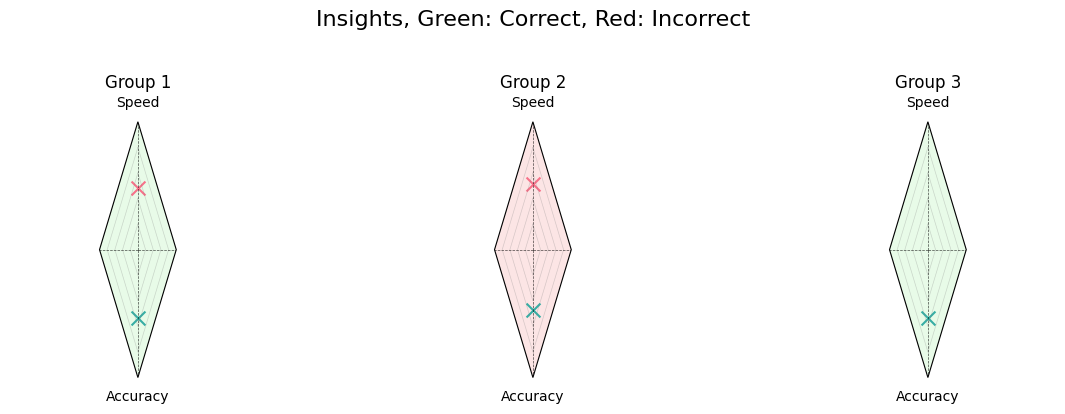

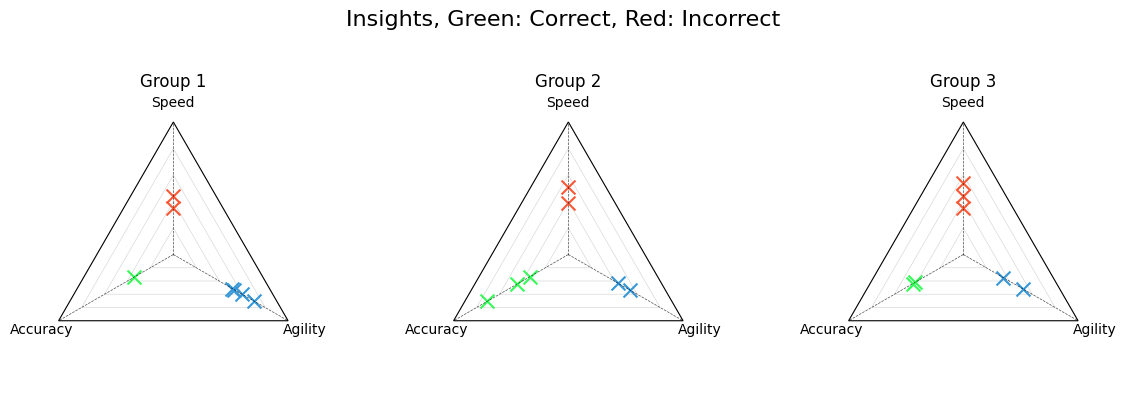

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon, Circle
from matplotlib.patches import RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.transforms import Affine2D
from matplotlib.spines import Spine
import matplotlib.colors as mcolors
import math
import seaborn as sns

def radar_factory(num_vars, frame='polygon', horizontal_scale=0.3, is_diamond=False):
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            if frame == 'polygon' and is_diamond:
                diamond_verts = np.array([
                    [0.5, 1.0],
                    [0.5 + 0.5*horizontal_scale, 0.5],
                    [0.5, 0.0],
                    [0.5 - 0.5*horizontal_scale, 0.5],
                ])
                return Polygon(diamond_verts, edgecolor="k", linewidth=2, closed=True)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=0.5, edgecolor="k", linewidth=2)
            elif frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'polygon' and is_diamond:
                verts = np.array([
                    [0, 1],
                    [horizontal_scale, 0],
                    [0, -1],
                    [-horizontal_scale, 0],
                ])
                path = Path(np.vstack([verts, verts[0]]),
                           [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY])
                spine = Spine(axes=self, spine_type='circle', path=path)
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'polygon':
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            elif frame == 'circle':
                return super()._gen_axes_spines()
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def create_radar_chart(categories, data, category_colors, title, horizontal_scale=0.3, ax=None):
    num_vars = len(categories)
    min_y = 0
    max_y = 1.1

    if len(category_colors) != num_vars:
        raise ValueError(f"Number of colors ({len(category_colors)}) must match number of categories ({num_vars})")

    diamond_mode = False
    if num_vars == 2:
        diamond_mode = True
        num_vars = 4
        theta = radar_factory(num_vars, horizontal_scale=horizontal_scale, is_diamond=True)
        original_colors = category_colors.copy()
        categories = [categories[0], '', categories[1], '']
        category_colors = [original_colors[0], '', original_colors[1], '']
        padded_data = []
        for d in data:
            if len(d) != 2:
                raise ValueError("2-class data requires exactly 2 values per dataset")
            padded_data.append([d[0], 0, d[1], 0])
        data = padded_data
        num_vars = 4
    else:
        theta = radar_factory(num_vars, is_diamond=False)

    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='radar'))
    else:
        fig = ax.figure

    normalized_data = []
    for d in data:
        row_sum = sum(d)
        if not diamond_mode:
            norm_d = [val / row_sum if row_sum != 0 else 0 for val in d]
        else:
            norm_d = [
                d[0]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,
                0,
                d[2]/(d[0]+d[2]) if (d[0]+d[2]) != 0 else 0,
                0
            ]
        normalized_data.append(norm_d)

    ax.grid(False)
    grid_values = np.linspace(min_y, max_y, 6)

    for g in grid_values:
        if diamond_mode:
            r = [g, g*horizontal_scale, g, g*horizontal_scale, g]
            ax.plot(np.append(theta, theta[0]), r, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
        else:
            polygon_vertices = [(t, g) for t in theta]
            polygon_vertices.append((theta[0], g))
            ax.plot(*zip(*polygon_vertices), color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    for t in theta:
        ax.plot([t, t], [min_y, max_y], color='black', linestyle='--', linewidth=0.5, alpha=0.7)

    for i, d in enumerate(normalized_data):
        max_value_index = np.argmax(d)
        category_color = (
            original_colors[0] if diamond_mode and max_value_index == 0 else
            original_colors[1] if diamond_mode and max_value_index == 2 else
            'gray' if diamond_mode else category_colors[max_value_index]
        )
        ax.scatter(theta[max_value_index], d[max_value_index], s=100, color=category_color, marker='x')

    ax.set_varlabels(categories)
    ax.set_ylim(min_y, max_y)
    ax.set_yticks([])
    ax.set_title(title, y=1.1)
    return fig, ax

def auto_subplot_grid(n):
    """Finds a near-square grid for `n` subplots."""
    cols = max(3,math.isqrt(n)) if math.isqrt(n) < 6 else 6
    rows = math.ceil(n / cols)
    return rows, cols


def plot_radar_charts(df, categories=None, colors=None, titles=None, correct=None):
    """
    df: DataFrame containing specimen level predictions
    categories: List of radar chart categories
    colors: List of category colors
    titles: List of chart titles
    correct: Dictionary mapping lot_id to boolean for background coloring
    """
    if categories is None:
        categories = df.columns.tolist()
    num_vars = len(categories)

    # Set default color scheme if none is provided
    if colors is None:
        colors = sns.color_palette("husl", len(categories))

    # Register projection
    radar_factory(4 if num_vars == 2 else num_vars, 
                is_diamond=True if num_vars == 2 else False)
    
    grouped = df.groupby(df.index)
    num_charts = len(grouped)
    rows, cols = auto_subplot_grid(num_charts)
    
    fig, axs = plt.subplots(rows, cols, 
                           subplot_kw=dict(projection='radar'), 
                           figsize=(cols * 4, rows * 4))
    axs = axs.flatten() if isinstance(axs, np.ndarray) else [axs]

    for i, (index, group) in enumerate(grouped):
        title = index if titles is None else titles[i]
        data = group.values.tolist()
        create_radar_chart(categories, data, colors, title, ax=axs[i])
        
        # Add background color based on correctness
        if correct is not None:
            is_correct = correct.get(index, False)
            bg_color = mcolors.to_rgba('lightgreen', 0.2) if is_correct else mcolors.to_rgba('lightcoral', 0.2)
            axs[i].set_facecolor(bg_color)

    # Hide unused subplots
    for j in range(num_charts, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.subplots_adjust(top=0.7)  # or another value < 1
    fig.suptitle("Insights, Green: Correct, Red: Incorrect", fontsize=16)
    plt.show()

if __name__ == "__main__":
    # Example DataFrame with duplicated indices
    data_dict = {
        'Speed': [88, 64, 99, 75, 60],
        'Accuracy': [78, 92, 77, 82, 85]
    }
    index = ['Group 1', 'Group 1', 'Group 2', 'Group 2', 'Group 3']
    correct_mapping = {
        'Group 1': True,
        'Group 2': False,
        'Group 3': True
    }
    df = pd.DataFrame(data_dict, index=index)

    categories = df.columns.tolist()
    colors = ['#FF5733', '#33FF57']

    plot_radar_charts(df, correct=correct_mapping)
    
    # generate a larger datasets with more datapoints for 3 variables
    data_dict = {
        'Speed': np.random.randint(1, 100, 21),
        'Accuracy': np.random.randint(1, 100, 21),
        'Agility': np.random.randint(1, 100, 21)
    }
    index = ['Group 1', 'Group 2', 'Group 3']* 7
    df = pd.DataFrame(data_dict, index=index)
    colors = ['#FF5733', '#33FF57', '#3498DB']
    plot_radar_charts(df, colors=colors)